# Learning latent variables through Autoencoder

## Import and load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds

import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
(ds_train, ds_test_), ds_info = tfds.load('mnist',
                              split=['test', 'test'],
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)

#fig = tfds.show_examples(ds_info, ds_train)

batch_size = 256
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image

ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)

## Encoder
The encoder is made up of multiple neural network layers, and it is best illustrated by using fully connected (dense) layers. The latent dimensionality should be smaller than the input dimensionality. This network topology forces the model to learn what is important and discard less important features from layer to layer, to finally come down to `z_dim` most important features.

### Dense-layer Encoder

In [3]:
# def Encoder(z_dim):
#   inputs = layers.Input(shape = (28, 28, 1))
#   x = inputs
#   x = layers.Flatten()(x)
#   x = layers.Dense(128, activation = 'relu')(x)
#   x = layers.Dense(64, activation = 'relu')(x)
#   x = layers.Dense(32, activation = 'relu')(x)
#   z = layers.Dense(z_dim, activation = 'relu')(x)

#   return Model(inputs = inputs, outputs = z, name = 'encoder')

### CNN Encoder
As CNNs are more efficient and better suited for image inputs, we will build the encoder using convolutional layers. Old CNNs, such as __VGG__, used max pooling for feature map downsampling, but modern networks tend to achieve that by using stride of 2 in the convolutional layers.

In [4]:
def Encoder(z_dim):
  inputs = Input(shape = (28, 28, 1))
  x = inputs
  x = Conv2D(filters = 8, kernel_size = (3,3), strides = 2, padding = 'same', activation = 'relu')(x)
  x = Conv2D(filters = 8, kernel_size = (3,3), strides = 2, padding = 'same', activation = 'relu')(x)
  x = Conv2D(filters = 8, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')(x)
  x = Flatten()(x)
  out = Dense(z_dim, activation = 'relu')(x)

  return Model(inputs = inputs, outputs = out, name = 'encoder')

## Decoder
The job of decoder is essentially the reverse of the encoder, which is to convert low-dimensional latent variables into high-dimensional output to look like the input image. There is no need for layers in the decoder to look like the encoder in reverse order, you can use completely different layers.

In [5]:
def Decoder(z_dim):
  inputs = Input(shape = (z_dim))
  x = inputs
  x = Dense((7*7*64), activation = 'relu')(x)  # consider our low resolution image is 7x7
  x = Reshape((7, 7, 64))(x)
  x = Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')(x)
  x = UpSampling2D((2,2))(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'sigmoid')(x)
  x = UpSampling2D((2,2))(x)
  out = Conv2D(filters = 1, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'sigmoid')(x)

  return Model(inputs = inputs, outputs = out, name = 'decoder')

## Building an autoencoder
For training, we will use L2 loss, this is implemented using mean squared error (MSE) to compare each of the pixels between the output and expected result.

In [6]:
class Autoencoder:
  def __init__ (self, z_dim):
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
    model_input = self.encoder.input
    model_output = self.decoder(self.encoder.output)

    self.model = Model(model_input, model_output)

In [14]:
autoencoder = Autoencoder(z_dim = 40)

In [15]:
autoencoder.model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 8)         80        
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 8)           584       
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 8)           584       
                                                                 
 flatten_2 (Flatten)         (None, 392)               0         
                                                                 
 dense_4 (Dense)             (None, 40)                15720     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         1842

In [16]:
path = "./models/autoencoder.h5"
os.makedirs("./models", exist_ok = True)

checkpoint = ModelCheckpoint(path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto', save_weights_only=False)
early = EarlyStopping(monitor= 'val_loss', mode = 'auto', patience = 10)

autoencoder.model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = 'mse',
    )

autoencoder.model.fit(ds_train, validation_data = ds_test, epochs = 100, callbacks = [checkpoint, early])

Epoch 1/100
39/40 [============================>.] - ETA: 0s - loss: 0.1116
Epoch 1: val_loss improved from inf to 0.07345, saving model to ./models/autoencoder.h5
40/40 [==============================] - 4s 28ms/step - loss: 0.1116 - val_loss: 0.0734
Epoch 2/100
38/40 [===========================>..] - ETA: 0s - loss: 0.0684
Epoch 2: val_loss improved from 0.07345 to 0.06587, saving model to ./models/autoencoder.h5
40/40 [==============================] - 1s 16ms/step - loss: 0.0684 - val_loss: 0.0659
Epoch 3/100
37/40 [==========================>...] - ETA: 0s - loss: 0.0608
Epoch 3: val_loss improved from 0.06587 to 0.05114, saving model to ./models/autoencoder.h5
40/40 [==============================] - 1s 14ms/step - loss: 0.0604 - val_loss: 0.0511
Epoch 4/100
36/40 [==========================>...] - ETA: 0s - loss: 0.0415
Epoch 4: val_loss improved from 0.05114 to 0.03239, saving model to ./models/autoencoder.h5
40/40 [==============================] - 1s 14ms/step - loss: 0.0407

8/8 [==============================] - 0s 2ms/step


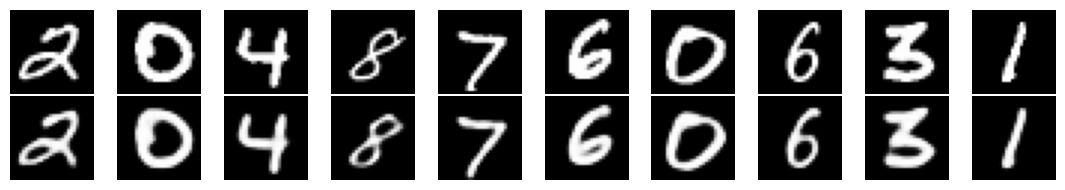

In [17]:
from tensorflow.keras.models import load_model
images, labels = next(iter(ds_test))
autoencoder.model = load_model(path)
outputs = autoencoder.model.predict(images)

# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize = (grid_col*1.1, grid_row))
i = 0

for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i,:,:,0], cmap='gray')
        axarr[row+1,col].axis('off')
        i += 1
f.tight_layout(h_pad=0.2, w_pad=0.1)
plt.show()


## Visualization

Let's build another model with only 2 latent variables which can be visualized in 2D graph. We will try to understand those hidden features that determine the reconstructed images.

In [18]:
autoencoder2 = Autoencoder(z_dim = 2)

early2 = EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 10)

autoencoder2.model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = "mse"
)

autoencoder2.model.fit(ds_train, validation_data = ds_test, epochs = 100, callbacks = [early2])

Epoch 1/100
40/40 [==============================] - 3s 18ms/step - loss: 0.1003 - val_loss: 0.0697
Epoch 2/100
40/40 [==============================] - 1s 13ms/step - loss: 0.0659 - val_loss: 0.0636
Epoch 3/100
40/40 [==============================] - 1s 13ms/step - loss: 0.0609 - val_loss: 0.0585
Epoch 4/100
40/40 [==============================] - 1s 13ms/step - loss: 0.0577 - val_loss: 0.0570
Epoch 5/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0566 - val_loss: 0.0561
Epoch 6/100
40/40 [==============================] - 1s 13ms/step - loss: 0.0559 - val_loss: 0.0556
Epoch 7/100
40/40 [==============================] - 1s 13ms/step - loss: 0.0554 - val_loss: 0.0551
Epoch 8/100
40/40 [==============================] - 1s 13ms/step - loss: 0.0549 - val_loss: 0.0547
Epoch 9/100
40/40 [==============================] - 1s 12ms/step - loss: 0.0544 - val_loss: 0.0541
Epoch 10/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0538 - val_loss: 0.0535

32/32 [==============================] - 0s 2ms/step


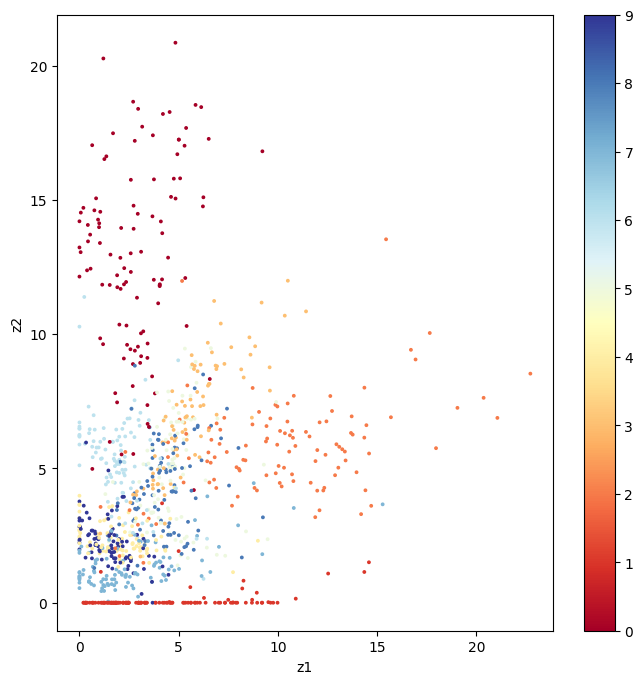

In [19]:
def preprocess_with_label(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.math.round(image / 255.)
  return image, label

ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

images, labels = next(iter(ds_test_label))
outputs = autoencoder2.encoder.predict(images)
plt.figure(figsize=(8,8))
plt.scatter(outputs[:,0], outputs[:,1], c=labels, cmap='RdYlBu', s=3)
plt.xlabel("z1")
plt.ylabel("z2")
plt.colorbar()

4/4 [==============================] - 0s 4ms/step


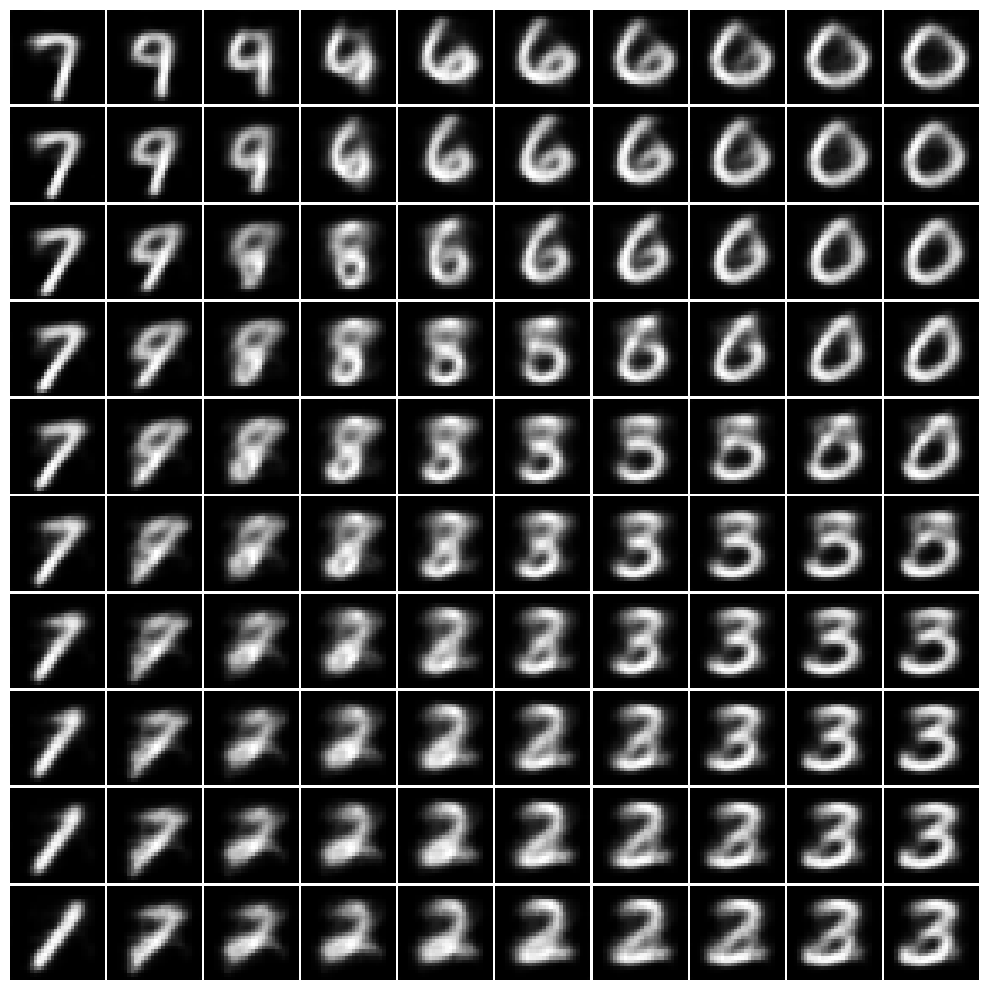

In [22]:
z_samples = np.array([[z1, z2] for z1 in range(1, 11, 1) for z2 in range(1, 11, 1)])
images = autoencoder2.decoder.predict(z_samples)

grid_col, grid_row = 10, 10
f, axarr = plt.subplots(grid_row, grid_col, figsize = (grid_col, grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        i += 1
f.tight_layout(h_pad=0.2, w_pad=0.1)
plt.show()

*__Comments:__*
- The latent features are features that are hidden and supposed not to be understandable by human. However, for the most simple case, we choose `z_dim` = 2 in order to visualize and understand those hidden features
- From the above visualization, $z_1$ seems to represent the "slope" of characeter
- $z_2$ represents for how "round" the character seems to be